I am using `vcfkit` for consistency with Victor.

However, it does not directly support specification of specific windows (ie TRD regions) to be calculated.

Instead, I will calculate TD with overlapping windows to then be able to choose the most approrpiate windows to average over.

In [29]:
library(data.table)
library(tidytable)
library(ggplot2)
source("~/BrusselSprouts/scripts/functions.R")

In [30]:
output_dir<-"/home/jnrunge/data/trd/TD_data"
if(!dir.exists(output_dir)){
    dir.create(output_dir)
}

In [5]:
vcf_file <- "/home/jnrunge/data/trd/full2489Matrix.vcf.gz"
window_size <- 10000
step_size <- 100
if(!file.exists(TD_file<-paste0(vcf_file,".td.txt.gz"))){
    cmd<-paste0("vk tajima ",window_size," ",step_size, " ", vcf_file, " | gzip > ", vcf_file,".td.txt.gz")
    stop("Run command")
}


In [31]:
TD_data<-fread(TD_file)
head(TD_data)

CHROM,BIN_START,BIN_END,N_Sites,N_SNPs,TajimaD
<chr>,<int>,<int>,<int>,<int>,<dbl>
chromosome1,0,10000,5021,2492,-2.015144
chromosome1,100,10100,4980,2514,-2.012050
chromosome1,200,10200,4933,2546,-2.004617
chromosome1,300,10300,4883,2579,-2.010570
chromosome1,400,10400,4837,2602,-2.002086
chromosome1,500,10500,4788,2626,-2.007805


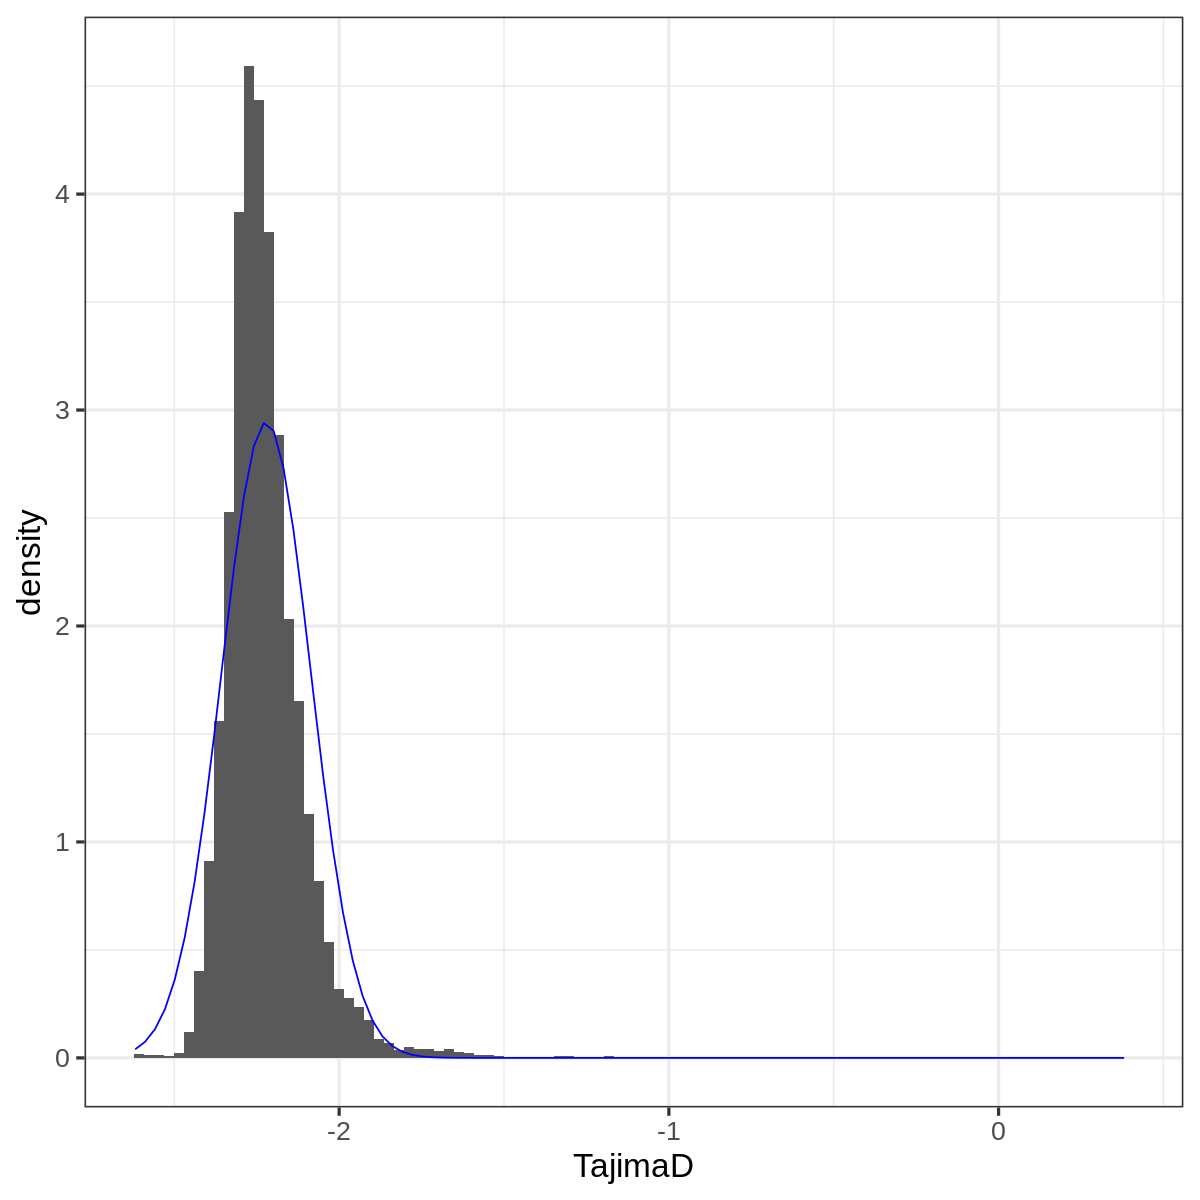

In [32]:
default_ggplot<-ggplot(TD_data, aes(TajimaD))+
geom_histogram(aes(y = after_stat(density)), bins=100)+
stat_function(
        fun = dnorm, 
        args = list(mean = mean(pull(TD_data, TajimaD)), sd = sd(pull(TD_data, TajimaD))), 
        color = "blue"
      )+theme_bw(20)
default_ggplot

In [33]:
getTDforAregion=function(chr,from,to){
    return_df<-filter(TD_data, CHROM==chr, BIN_START>=from, BIN_END<=to)
    return(mean(pull(return_df, TajimaD)))
}

In [34]:
# load all TRD regions
TRD_regions<-fread_and_bind_files(list.files("/home/jnrunge/data/TRD/results/shiny/",pattern="TRD_regions.csv.gz$",full.names = TRUE))
TRD_regions<-mutate(TRD_regions, file=basename(file))%>%separate(file, c("cross","discard"), "-")%>%select(-discard)%>%filter(chr_start==chr_end)%>%
rename(chr=chr_start)%>%select(-chr_end)
# translate global positions to chr positions

for(c in select(TRD_regions,cross)%>%distinct()%>%pull())
    {
    AF<-fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))
    
    tmp_TRD_regions<-filter(TRD_regions, cross==c)%>%select(-any_of("start"))%>%
              left_join(select(AF, chr,pos,global_pos)%>%
              rename(global_start=global_pos), by=c("chr","global_start"))%>%rename(start=pos)
    
    TRD_regions<-filter(TRD_regions, cross!=c)%>%bind_rows(tmp_TRD_regions)
}

TRD_regions<-mutate(TRD_regions, end=global_end-(global_start-start))

head(TRD_regions)

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end
<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>
1,155,chromosome2,668344,790905,122561,ChrisC1,444778,567339
9,206,chromosome14,9398197,9591625,193428,ChrisC1,224256,417684
13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958
14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299
4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414
11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250


In [35]:
getSDmultiplier<-function(x, mean, sd){
    return((x - mean) / sd)
}

In [37]:
TRD_regions<-mutate(TRD_regions, TD_sd_multi=NA, TD_ecdf=NA, TD=NA)
for(i in 1:nrow(TRD_regions)){
    TRD_regions_slice<-slice(TRD_regions,i)
    TD_value<-getTDforAregion(pull(TRD_regions_slice,chr),pull(TRD_regions_slice,start),pull(TRD_regions_slice,end))
    saveRDS(default_ggplot+geom_vline(xintercept=TD_value, color="red"), paste0(output_dir,"/",pull(TRD_regions_slice, cross),".",pull(TRD_regions_slice, ID),".",
                     "TD_plot",".RDS"))
    TRD_regions<-mutate(TRD_regions,
                        TD=ifelse(row_number()==i,TD_value,TD),
                       TD_sd_multi=ifelse(row_number()==i,
                       getSDmultiplier(TD_value, mean(pull(TD_data, TajimaD)), sd(pull(TD_data, TajimaD))),TD_sd_multi),
                        TD_ecdf=ifelse(row_number()==i,
                       ecdf(pull(TD_data, TajimaD))(TD_value),TD_ecdf))
    }

In [39]:
head(TRD_regions)
fwrite(select(TRD_regions, cross, ID, TD, TD_sd_multi, TD_ecdf), paste0(output_dir,"/","TD_plot_data",".csv.gz"))

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,TD_sd_multi,TD_ecdf,TD
<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,155,chromosome2,668344,790905,122561,ChrisC1,444778,567339,0.35996150,0.7510001,-2.172417
9,206,chromosome14,9398197,9591625,193428,ChrisC1,224256,417684,-0.34104881,0.3813034,-2.267406
13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958,-0.05943522,0.5518305,-2.229246
14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299,-0.02183141,0.5731611,-2.224151
4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414,-0.35851533,0.3705288,-2.269773
11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250,0.43095539,0.7729695,-2.162797
